# Dimitrios Loupas - Computational Biophysics course 

## DROSSEL-SCHWABL FOREST FIRE MODEL PAPER GRAPHS

######  B.  Drossel  and  F.  Schwabl.  Self-organized  critical  forest-fire  model.Phys.Rev. Lett., 69(11):1629–1632, Sep 1992.

For the forest fire model we implement the following rules:

1) item  Choose an arbitrary site in the system. If it is not occupied by a tree, proceed with rule 2. If it is occupied by a tree, then ignite the tree and burn down the forest cluster to which the tree belongs. While burning the trees, evaluate the properties of the cluster as size and radius. Proceed with rule 2
2) Choose $p/f$ arbitrary sites in the system and grow a tree at all chosen empty sites. Proceed with rule 1


In [7]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from scipy import ndimage
from scipy.sparse import random
from tqdm import tqdm
from scipy.ndimage import measurements
import scipy.optimize as opt
from scipy.sparse import random
%matplotlib inline

In [3]:
class Forest:
    
    """ class to define the grid of the computational space and run the simulation"""
    
    
    
    def __init__(self,N):
        
        self.N=N #grid dimension
        self.grid=np.zeros((self.N,self.N)) #grid matrix
        self.empty, self.tree, self.burn=0, 1, 2 #states of the system
        self.pf=125 #p/f parameter
        self.density=0.6 #initrial density of the system
        self.T=40000 #time steps
        self.fig=0 #for figs and animation
        self.ax=0
        self.im=0
        self.cluster_size=np.arange(self.grid.size)+1 #sizes of clusters
        self.cluster_freq=np.zeros(self.grid.size) #matrix for frequency clusters
        self.cluster_radius=np.zeros(self.grid.size) #matrix for cluster radius
        self.boolean=0
        #np.random.seed(200) #random seed
    
    #initiallize grid
    def initiallize(self):
        for i in range(0,self.N):
            for j in range(0,self.N):
                if np.random.rand()<=self.density:
                    self.grid[i][j]=self.tree
                else:
                    self.grid[i][j]=self.empty
        
    
        
    
    
    #function to determine the cluster of a 2d grid
    def cluster_fire(self,array):
    
        clusters=[] #list for clusters 
        clusters_pos=[] #list for cluster positions
        array_burned = np.zeros(array.size,dtype=int) #row vector of the array
    
        lbl, nlbl = ndimage.label(array) #finds the clusters and labels them 
    
        labels=np.arange(1,nlbl+1) #vector with all the labels 
    
        positions=np.arange(array.size).reshape(array.shape) #matrix with position numbers in each cell 
    
        #loop that runs in the vector of labels and for each label holds the number of 1's in each cluster 
        # the position of each member in the cluster e.g [1,1] at [12,13]
        for i in labels: 
            clusters.append(array[lbl==i])
            clusters_pos.append(positions[lbl==i])
    
        for cluster in clusters:                     #it iterates the list of forest clusters
    
            if len(cluster[cluster==2])>0:           #check if there is a value of 2 in the cluster
                                                 #if one cluster tree it's struck by lightning the whole cluster
                cluster.fill(2)                      #it's burned down

        #new matrix with the burned cluster replaced with 2's
        for clust, pos in zip(clusters,clusters_pos):

            for i in range(0,len(clust)):
                array_burned[pos[i]] = clust[i]
            
        array_burned = array_burned.reshape(array.shape) #new array with the burned cluster
    
        
    
        return array_burned
        
    
    def statistics(self):
        grid_copy=np.copy(self.grid)
        grid_points=grid_copy[grid_copy==2] #size of cluster
        self.cluster_freq[len(grid_points)-1]=self.cluster_freq[len(grid_points)-1]+1 #add to freq mat
        #cm calculation 
        xcm=0
        ycm=0
        for i in range(0,self.N):
            for j in range(0,self.N):
                if grid_copy[i][j]==2:
                    xcm=xcm+j
                    ycm=ycm+self.N-1-i
        xcm=xcm/len(grid_points)
        ycm=ycm/len(grid_points)
        Rsq=0
        for i in range(0,self.N):
            for j in range(0,self.N):
                if grid_copy[i][j]==2:
                    Rsq=Rsq+abs(xcm-j)**2+abs(ycm-self.N+1+i)**2
    
        Rsq=Rsq/len(grid_points)
        self.cluster_radius[len(grid_points)-1]=self.cluster_radius[len(grid_points)-1]+Rsq
        
    
    def rule1(self):
        #choose random position in the grid
        xr=np.random.randint(0,self.N-1)
        yr=np.random.randint(0,self.N-1)

        if self.grid[xr][yr]==self.tree:
            self.grid[xr][yr]=self.burn
            self.grid=self.cluster_fire(self.grid) #find cluster
            if self.boolean==1:
                self.statistics() #collect statistics
            
            self.grid[self.grid==2]=0 #remove the burned cluster
           
        else:
            return
        
        
    def rule2(self):
        #new p/f trees creation
        new_trees=1*(random(self.N, self.N, density=self.pf/(self.N)**2, random_state=None, data_rvs=None)>0).A
        self.grid=(new_trees+self.grid>0)*1 #new trees in the grid only in positions without a tree
        
        
               
    #to thermalize system
    def thermalization(self):
        self.boolean=0
        for n in tqdm(range(0,1000)):
            self.rule1()
            self.rule2()
            
    #run model
    def run(self):
        self.boolean=1

        for n in tqdm(range(0,self.T)):
            self.rule1()
            self.rule2()
        #self.burning()
        #self.new_tree()
        #self.pr(self.grid)
        #self.ignite_tree()   
        
        
        #print(pf)
    
    
    #return statistics
    def stat_return(self):
        return self.cluster_size, self.cluster_freq, self.cluster_radius
    
    
    def animate(self,i):
        self.im.set_data(self.grid)
        self.rule1()
        self.rule2()
      
   

    #animation
    def animation(self):
        colors_list = [(0.4,0,0), (0,0.5,0), (1,0,0), 'orange']
        cmap = colors.ListedColormap(colors_list)
        bounds = [0,1,2,3]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        self.fig = plt.figure(figsize=(25/3, 6.25))
        self.ax = self.fig.add_subplot(111)
        self.ax.set_axis_off()
        self.im = self.ax.imshow(self.grid, cmap=cmap, norm=norm)
        self.anim = animation.FuncAnimation(self.fig, self.animate,frames=10,interval=100)
        plt.show()

 
    #print forest  
    def _print(self):
        colors_list = [(0.4,0,0), (0,0.5,0), (1,0,0), 'orange']
        cmap = colors.ListedColormap(colors_list)
        bounds = [0,1,2,3]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        self.fig = plt.figure(figsize=(25/3, 6.25))
        self.ax = self.fig.add_subplot(111)
        self.ax.set_axis_off()
        self.im = self.ax.imshow(self.grid,cmap=cmap, norm=norm)
        print(self.grid)

In [4]:
obj=Forest(100)
obj.thermalization()
obj.run()

100%|█████████████████████████████████████| 40000/40000 [12:22<00:00, 53.86it/s]


In [5]:
x,y,z=obj.stat_return()

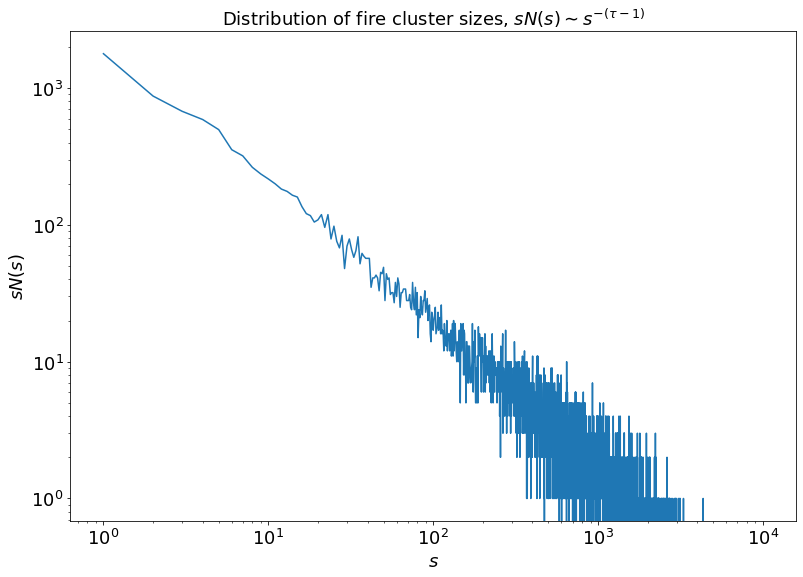

In [8]:
#Distribution of cluster sizes
plt.figure(figsize=(13,9))
plt.plot(x,y)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$s$",fontsize=18)
plt.ylabel("$sN(s)$",fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title("Distribution of fire cluster sizes, $sN(s)\sim s^{-(τ-1)}$",fontsize=18)
plt.show()

/var/folders/kf/s4pc0xrj45bdw7hnvhkny8y80000gn/T/ipykernel_50825/3400036522.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[1:],np.sqrt(z[1:]/y[1:]))


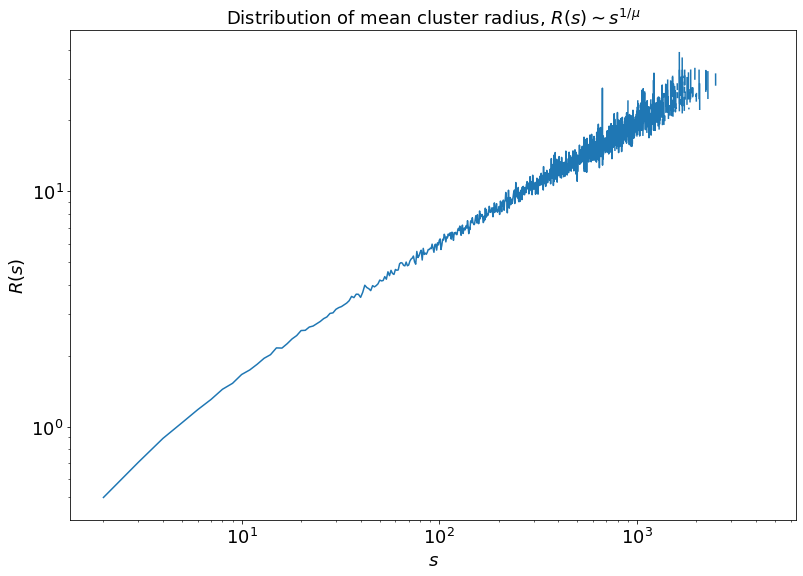

In [9]:
#Distribution of cluster radius
plt.figure(figsize=(13,9))
plt.plot(x[1:],np.sqrt(z[1:]/y[1:]))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$s$",fontsize=18)
plt.ylabel("$R(s)$",fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title("Distribution of mean cluster radius, $R(s)\sim s^{1/μ}$",fontsize=18)
plt.show()

## Linear regrassion to determine critical exponents

In [10]:
#linear function with parameter a,b in order to perform linear regression
def linear(x,a,b):
    return a+b*x

In [11]:
#exp function
def exp(x,a,b):
    return a*x**b

In [12]:
#for linear regression
popt, _ = opt.curve_fit(linear, np.log10(x[1:400]),np.log10(y[1:400]) )
print("a,b estimates for the linear model:")
print("a=", popt[0])
print("b=", popt[1])

a,b estimates for the linear model:
a= 3.401038213429502
b= -1.0558298748335837


In [13]:
#for linear regression
popt1, _ = opt.curve_fit(linear, np.log10(x[10:350]), np.log10(np.sqrt(z[10:350]/y[10:350])))
print("a,b estimates for the linear model:")
print("a=", popt1[0])
print("b=", popt1[1])

a,b estimates for the linear model:
a= -0.28045317429052313
b= 0.527664507818186


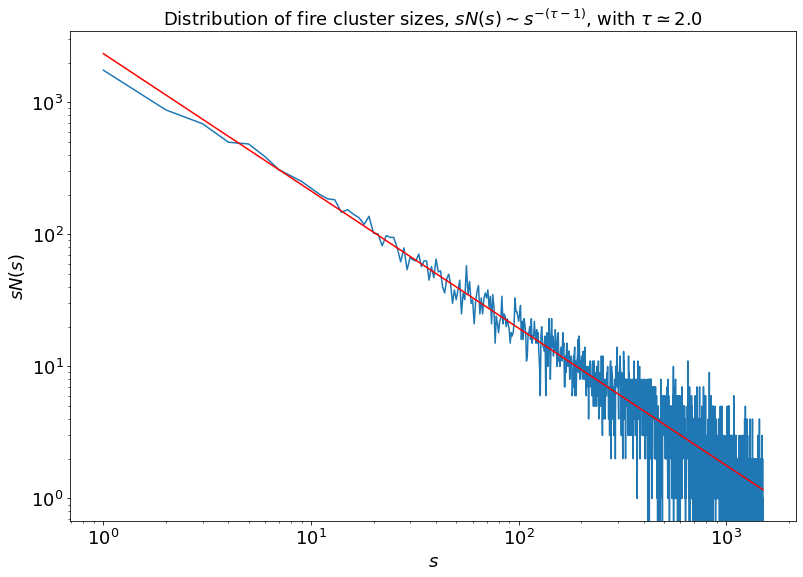

In [92]:
#Distribution of cluster sizes
plt.figure(figsize=(13,9))
plt.plot(x[:1500],y[:1500])
plt.plot(x[:1500], exp(x[:1500], 10**(popt[0]), popt[1]),'r',label='linear model')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$s$",fontsize=18)
plt.ylabel("$sN(s)$",fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title("Distribution of fire cluster sizes, $sN(s)\sim s^{-(τ-1)}$, with $τ\simeq 2.0$",fontsize=18)
plt.savefig("ClustersFFM.png", transparent=True)
plt.show()

/var/folders/kf/s4pc0xrj45bdw7hnvhkny8y80000gn/T/ipykernel_43259/3993784227.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[1:1500],np.sqrt(z[1:1500]/y[1:1500]))


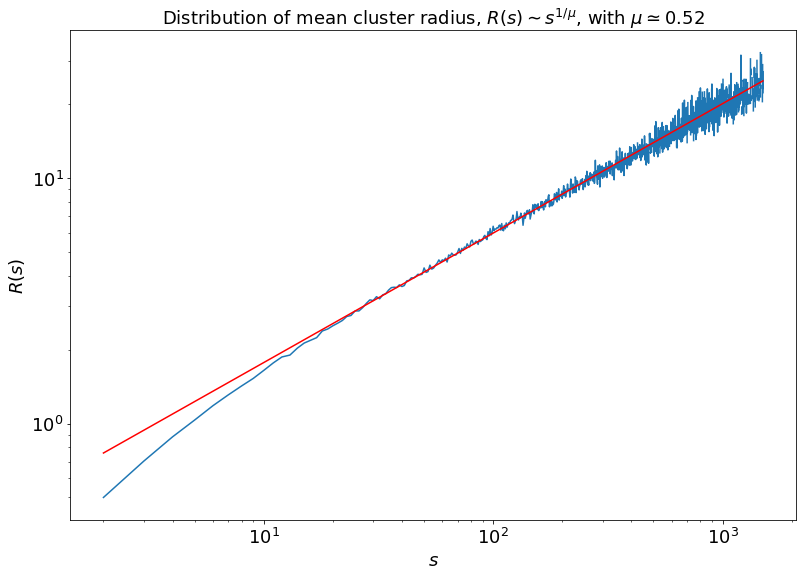

In [106]:
#Distribution of cluster radius
plt.figure(figsize=(13,9))
plt.plot(x[1:1500],np.sqrt(z[1:1500]/y[1:1500]))
plt.plot(x[1:1500], exp(x[1:1500], 10**(popt1[0]), popt1[1]),'r',label='linear model')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$s$",fontsize=18)
plt.ylabel("$R(s)$",fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title("Distribution of mean cluster radius, $R(s)\sim s^{1/μ}$, with $μ\simeq 0.52$",fontsize=18)
plt.savefig("RadiusClustersFFM.png", transparent=True)
plt.show()

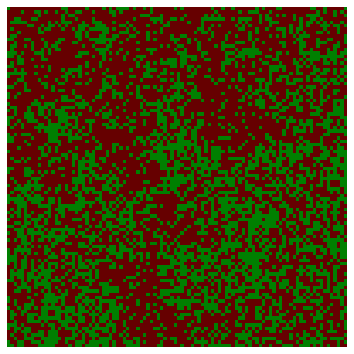

In [20]:
obj.animation()